In [2]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import pandas as pd
from pytictoc import TicToc
t = TicToc()

import astropy.units as u
from astropy.constants import c, G, k_B, m_e, M_sun
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources
import pandas as pd
#%matplotlib widget

# import agnpy classes
import agnpy
from agnpy.emission_regions import Blob
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import RingDustTorus, SSDisk
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed

load_mpl_rc()

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

from AgnpyEC import AgnpyEC


In [3]:
#######################################################################################################
### read data
#######################################################################################################
### Template source
source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/PKS1510-089_example.csv') 

### My source
#source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/J0854+2006_flux.csv') 

freq = source['freq'].values
flux = source['flux'].values
flux_err = source['flux_err'].values

### set flux error which is nan to 0.01
fluxerr_nan = np.where( np.isnan(flux_err ))[0]
flux_err[fluxerr_nan] = 0.01
### find flux index which is not nan
flux_NOTnan = np.where( (~np.isnan(flux)) & (flux > 0) )[0]
### save new data into array
freq = freq[flux_NOTnan]
flux = flux[flux_NOTnan]
flux_err = flux_err[flux_NOTnan]

flux_err_correct = flux_err/0.434*flux
#######################################################################################################
### systematic errors
#######################################################################################################
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
### define energy ranges
nu_vhe = 2.42E25 # [Hz]
nu_he = 2.42E22 # [Hz]
nu_x_ray_max = 4.25E19 # [Hz]
nu_x_ray_min = 7.25E16 # [Hz]
vhe_gamma = freq >= nu_vhe
he_gamma = (freq >= nu_he) * (freq  < nu_vhe)
x_ray = (freq  >= nu_x_ray_min) * (freq  < nu_x_ray_max)
uv_to_radio = freq  < nu_x_ray_min

### declare systematics
y_err_syst = np.zeros(len(freq ))
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = flux * y_err_syst

# define the data1D object containing it
sed = data.Data1D("sed", freq, flux, staterror = flux_err_correct, syserror = y_err_syst)

#######################################################################################################
# declare a model
#######################################################################################################
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361                                     # redshift 
d_L = Distance(z=z).to("cm")                  # luminosity distance [cm]

# blob
Gamma = 20                                    # Lorentz factor (calculate
delta_D = 25                                  # doppler factor δ (fit
Beta = np.sqrt(1 - 1 / Gamma**2)              # jet relativistic speed (calculate
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta     # viewing angle (calculate
B = 0.35                                      # magnetic field strength [G] (fit

# disk
L_disk = 6.7e45 * u.Unit("erg s-1")           # disk luminosity (???
M_BH = 5.71E7 * M_sun                         # black hole mass (???
eta = 1/12                                    # accretion efficiency η (??? 
 
m_dot = (L_disk / (eta * c ** 2)).to("g s-1") # accretion rate (M dot) (calculate
R_g = ( (G * M_BH) / c ** 2).to("cm")          # Schwarzschild radius [cm] (calculate
R_in = 6 * R_g                                # [cm] (calculate
R_out = 10000 * R_g                           # [cm] (calculate

# DT
xi_dt = 0.6                                   # fraction of disk luminosity reprocessed by the DT ξ = f_IR (
T_dt = 1e3                                    # [K] (v
R_dt = 6.47 * 1e18                            # [cm] (v

# size and location of the emission region
t_var = 86400*0.5                             # varaibility timescale of emission region [sec] (fit
r = 6e17                                      # size of emission region [cm]

# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z = z                                # redshift 
agnpy_ec.z.freeze()
agnpy_ec.d_L = d_L.cgs.value                  # luminosity distance [cm]
agnpy_ec.d_L.freeze()
# -- SS disk
agnpy_ec.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))  # disk luminosity
agnpy_ec.log10_L_disk.freeze()
agnpy_ec.log10_M_BH = np.log10(M_BH.to_value("g")) # black hole mass
agnpy_ec.log10_M_BH.freeze()
agnpy_ec.m_dot = m_dot.to_value("g s-1")      # accretion rate
agnpy_ec.m_dot.freeze()
agnpy_ec.R_in = R_in.to_value("cm")           # [cm]
agnpy_ec.R_in.freeze()
agnpy_ec.R_out = R_out.to_value("cm")         # [cm]
agnpy_ec.R_out.freeze()
# -- Dust Torus
agnpy_ec.xi_dt = xi_dt                        # fraction of disk luminosity reprocessed by the DT
agnpy_ec.xi_dt.freeze()
agnpy_ec.T_dt = T_dt                          # [K]
agnpy_ec.T_dt.freeze()
agnpy_ec.R_dt = R_dt                          # [cm]
agnpy_ec.R_dt.freeze() 
# - blob parameters
agnpy_ec.delta_D = delta_D                    # doppler factor δ
agnpy_ec.delta_D.freeze()
agnpy_ec.log10_B = np.log10(B)                # magnetic field sterength [G]
agnpy_ec.mu_s = mu_s                          # viewing angle
agnpy_ec.mu_s.freeze()
agnpy_ec.t_var = t_var                        # varaibility timescale of emission region [sec]
agnpy_ec.t_var.freeze()
agnpy_ec.log10_r = np.log10(r)                # size of emission region [cm]
agnpy_ec.log10_r.freeze()
# - EED
agnpy_ec.log10_k_e = np.log10(0.05)           # opacity [cm^-3]
agnpy_ec.p1 = 1.8                             # electron distribution index
agnpy_ec.p2 = 3.5                             # electron distribution index
agnpy_ec.log10_gamma_b = np.log10(500)        # lorentz break factor
agnpy_ec.log10_gamma_min = np.log10(1)        # minimum lorentz factor
agnpy_ec.log10_gamma_min.freeze()
agnpy_ec.log10_gamma_max = np.log10(3e4)      # minimum lorentz factor
agnpy_ec.log10_gamma_max.freeze()


In [4]:
#######################################################################################################
### fit using the Levenberg-Marquardt optimiser
#######################################################################################################
fitter = Fit(sed, agnpy_ec, stat = Chi2(), method = LevMar())

# Set minimum and maximum frequency to proced model fit
min_x = 1.0E7
max_x = 1.0E30
sed.notice(min_x, max_x)

t.tic()
#######################################################################################################
### perform model fit
#######################################################################################################
result = fitter.fit()
t.toc()

print('=================================================')
print("Model fit Parameters")
print('=================================================')
print("Model fit succesful??", result.succeeded)
print(result.format())



Elapsed time is 16.422968 seconds.
Model fit Parameters
Model fit succesful?? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 5507.22
Final fit statistic   = 692.529 at function evaluation 90
Data points           = 42
Degrees of freedom    = 37
Probability [Q-value] = 8.04712e-122
Reduced statistic     = 18.717
Change in statistic   = 4814.69
   ec.log10_k_e   -2.08515     +/- 0.210622    
   ec.p1          2.00229      +/- 0.0546012   
   ec.p2          3.2789       +/- 0.028584    
   ec.log10_gamma_b   3.02271      +/- 0.0681174   
   ec.log10_B     -0.402867    +/- 0.00913168  


Emission Parameters
* spherical emission region
 - R_b (radius of the blob): 2.38e+16 cm
 - t_var (variability time scale): 5.00e-01 d
 - V_b (volume of the blob): 5.64e+49 cm3
 - z (source redshift): 0.36
 - d_L (source luminosity distance):6.13e+27 cm
 - delta_D (blob Doppler factor): 2.50e+01
 - Gamma (blob Lorentz factor): 2.00e+01
 - Beta (blob relativistic velocity): 9.99e-01
 - theta_s (jet viewing angle): 2.22e+00 deg
 - B (magnetic field tangled to the jet): 3.95e-01 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - broken power law
 - k_e: 8.22e-03 1 / cm3
 - p1: 2.00
 - p2: 3.28
 - gamma_b: 1.05e+03
 - gamma_min: 1.00e+00
 - gamma_max: 3.00e+04
jet power in particles: 2.48e+45 erg / s
jet power in B: 2.65e+44 erg / s
Radiative Processes Parameters
* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 1.14e+41 g
 - L_disk (disk luminosity): 6.70e+45 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion 

Text(0.5, 1.0, 'PKS 1510-089 SED Fitting ($\\chi^2$ = 18.72)')

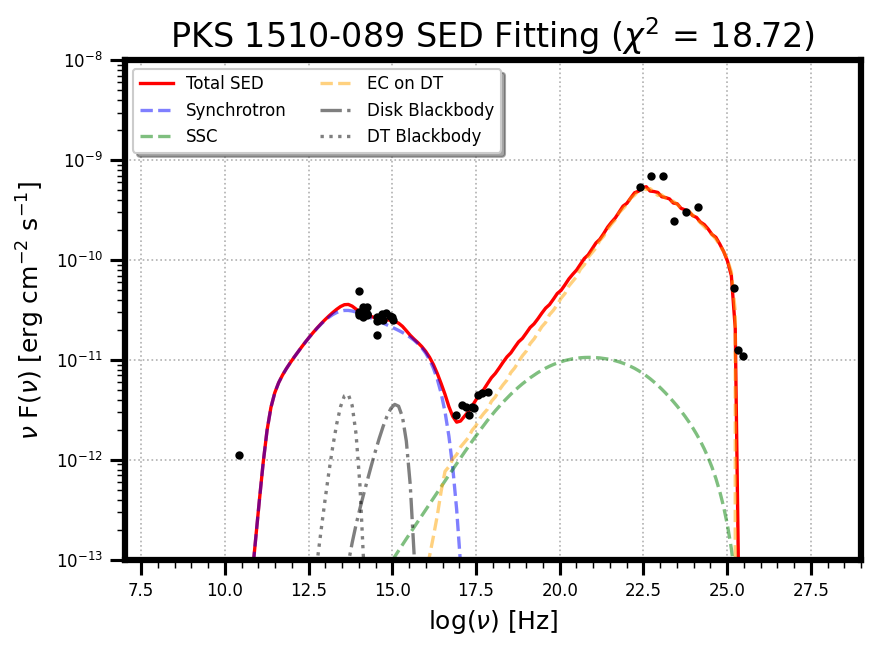

In [5]:
#######################################################################################################
### define the emission region and the thermal emitters
#######################################################################################################
k_e = 10**agnpy_ec.log10_k_e.val * u.Unit("cm-3")
p1 = agnpy_ec.p1.val
p2 = agnpy_ec.p2.val
gamma_b = 10**agnpy_ec.log10_gamma_b.val
gamma_min = 10**agnpy_ec.log10_gamma_min.val
gamma_max = 10**agnpy_ec.log10_gamma_max.val
B = 10**agnpy_ec.log10_B.val * u.G
r = 10**agnpy_ec.log10_r.val * u.cm
delta_D = agnpy_ec.delta_D.val
R_b = c.value * agnpy_ec.t_var.val * agnpy_ec.delta_D.val / (1 + agnpy_ec.z.val)*100

### blob definition
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(
    R_b*u.cm,
    z,
    delta_D,
    Gamma,
    B,
    k_e,
    spectrum_dict,
    spectrum_norm_type="differential",
    gamma_size = 500,  # gamma_size = 500
)
print('=================================================')
print("Emission Parameters")
print('=================================================')
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

#######################################################################################################
### Disk and DT definition
#######################################################################################################
L_disk = 10 ** agnpy_ec.log10_L_disk.val * u.Unit("erg s-1")
M_BH = 10 ** agnpy_ec.log10_M_BH.val * u.Unit("g")
m_dot = agnpy_ec.m_dot.val * u.Unit("g s-1")
eta = (L_disk/(m_dot*c**2)).to_value("")
R_in = agnpy_ec.R_in.val * u.cm
R_out = agnpy_ec.R_out.val * u.cm
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out)
dt = RingDustTorus(L_disk, xi_dt, T_dt * u.K, R_dt = R_dt * u.cm)
print('=================================================')
print("Radiative Processes Parameters")
print('=================================================')
print(disk)
print(dt)

#######################################################################################################
### define define the radiative processes
######################################################################################################
synch = Synchrotron(blob, ssa = True)
ssc = SynchrotronSelfCompton(blob, synch)
ec_dt = ExternalCompton(blob, dt, r)
# SEDs
nu = np.logspace(7, 30, 200) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)
ec_dt_sed = ec_dt.sed_flux(nu)
disk_bb_sed = disk.sed_flux(nu, z)
dt_bb_sed = dt.sed_flux(nu, z)
total_sed = synch_sed + ssc_sed + ec_dt_sed + disk_bb_sed + dt_bb_sed

#######################################################################################################
### define emission and radiative process parameters
#######################################################################################################
freq = nu.value / (1 + z)
### symchrotron radiaiton
sync = synch_sed
### synchrotron self-compton
ssc = ssc_sed
### external compton (EC) on dust torus (DT)
ec_dt = ec_dt_sed
### disk blackbody radiation
disk_bb = disk_bb_sed
### disk torus blackbody
dt_bb = dt_bb_sed

#######################################################################################################
### plot model fit results!
#######################################################################################################
data_x = sed.x
data_y = sed.y
y_err_lin = sed.get_error()

fit_x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
fit_y = agnpy_ec(fit_x).to_value()

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3
    
fig, ax = plt.subplots()

ax.plot(np.log10(fit_x/(1+z)), fit_y, '-', color = 'red', label = 'Total SED')
ax.errorbar(np.log10(data_x/(1+z)), data_y, yerr = flux_err_correct, marker=".", color = "black", ecolor = "black", linestyle = '') 

#ax.plot(np.log10(freq), total_sed, '-', color = 'red', alpha = 0.5, label = 'Synchrotron')
ax.plot(np.log10(freq), sync, '--', color = 'blue', alpha = 0.5, label = 'Synchrotron')
ax.plot(np.log10(freq), ssc, '--', color = 'green', alpha = 0.5, label = 'SSC')
ax.plot(np.log10(freq), ec_dt, '--', color = 'orange', alpha = 0.5, label = 'EC on DT')
ax.plot(np.log10(freq), disk_bb, '-.', color = 'black', alpha = 0.5, label = 'Disk Blackbody')
ax.plot(np.log10(freq), dt_bb, ':', color = 'black', alpha = 0.5, label = 'DT Blackbody')

ax.set_xlim (7, 29)
ax.set_ylim (10**-13, 10**-8) 
plt.yscale('log')

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('$\\nu$ F($\\nu$) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 12)
plt.yticks(fontsize = 8)
plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1, ncol = 2) 

plt.grid(True)
figurename = 'PKS 1510-089 SED Fitting ($\\chi^2$ = %.2f)' %(float(result.rstat))
plt.title(figurename, fontsize = 16)


In [6]:
blob.theta_s

<Quantity 2.21942561 deg>

In [5]:
# from datetime import datetime, date, timedelta

# print(datetime.today())

In [6]:
# from astropy.cosmology import Planck18

# z =  0.007967
# Planck18.angular_diameter_distance(z)

In [7]:
# #######################################################################################################
# ### save SED file into csv form
# #######################################################################################################
# import pandas as pd

# def ClearData():
#     data = {
#     'freq': [],
#     'flux': [],
#     'flux_err': []
#       }
#     return data

# df = ClearData()

# # read the 1D data
# sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv")
# sed_table = Table.read(sed_path)

# for i in range(0, len(sed_table)):
#     df['freq'].append(sed_table[i][0]/4.13E-15) # eV to Hz
#     df['flux'].append(sed_table[i][1])
#     df['flux_err'].append(sed_table[i][2])

# CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED code and data/PKS1510-089_example.csv'   
# dff = pd.DataFrame(df)      
# dff.to_csv(CSVfile, index = False)